In [2]:
import numpy as np
with open('data_1.npy','rb') as f:
  data = np.load(f)


Covariancee Matrix ∑ =  [[1.18943074 0.62561617]
 [0.62561617 2.13989623]]
Mean x̄ =  [4.89603509 0.97500178]
Coordinates of Outliers are : 
[-2.  2.]
[-2. -4.]
[10.  7.]


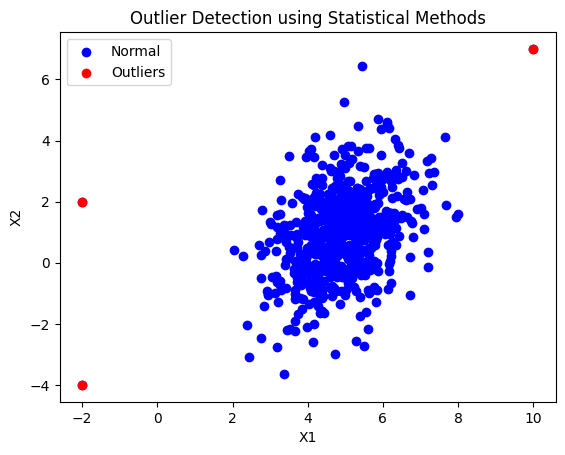

In [3]:
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal

#Covariance Matrix & Mean Calculation
CovarianceMatrix = np.cov(data)
mu = np.mean(data,axis=1)

print("Covariancee Matrix ∑ = ",CovarianceMatrix)
print("Mean x̄ = ",mu)

#Creating a model using Multivariate Gaussian Distribution
model = multivariate_normal(mean=mu, cov=CovarianceMatrix)

#Getting Outlier Score(*probability score) for each data
outlier = model.pdf(data.T).reshape(-1)

IDs = outlier.argsort()[:3]
OutliersCoordinates = np.array([data.T[i] for i in IDs])
print("Coordinates of Outliers are : ")
for i in IDs:
  print(data.T[i])


plt.scatter(data.T[:, 0], data.T[:, 1], color='b')
plt.scatter(OutliersCoordinates[:, 0], OutliersCoordinates[:, 1], color='r')
plt.title("Outlier Detection using Statistical Methods")
plt.xlabel("X1")
plt.ylabel("X2")
plt.legend(['Normal', 'Outliers'])
plt.show()

[-2. -3.]
[-1. -2.]
[1. 2.]
[2. 1.]


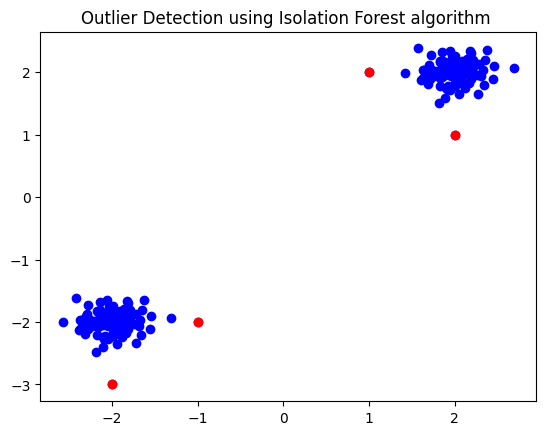

In [6]:
import matplotlib.pyplot as plt
import numpy as np
import math
from collections import Counter

"""
There are 3 code blocks to be filled to have the iForest model run.
You should not need to make changes to other code segments.
You should not need to alter the function interfaces.
"""
class Node:
    def __init__(self, val=None, right=None, left=None):
        self.val = val  # store the IDs of data points, only for leaf nodes
        self.right = right
        self.left = left


class iTree:
    def __init__(self):
        self.tree = None
        self.n_features = None

    def get_split(self, data, inds):
        f = np.random.randint(0, self.n_features)
        min_val = np.min(data[inds, f])
        max_val = np.max(data[inds, f])
        v = np.random.uniform(min_val, max_val)
        """
        Code block: 1
        # randomly choose (1) which feature f to split, (2) the feature split value v
        """
        return f, v

    def split(self, data, IDs):
        # split the current set of data points
        f, v = self.get_split(data, IDs)
        left_ind = []
        right_ind = []
        for i in IDs:
            if data[i, f] <= v:
                left_ind.append(i)
            else:
                right_ind.append(i)
        return left_ind, right_ind

    def buildTree(self, data, IDs):
        # leaf node
        if len(IDs) < 2:
            return Node(val=IDs)
        # non-leaf node
        """
        Code block: 2
        # build the non-leaf node, which recursively makes the tree deeper
        """
        f, v = self.get_split(data, IDs)
        left_ind, right_ind = self.split(data, IDs)

        left = self.buildTree(data, left_ind)
        right = self.buildTree(data, right_ind)

        return Node(left=left, right=right)

    def fit(self, data):
        self.n_features = data.shape[1]
        IDs = np.arange(data.shape[0])
        self.tree = self.buildTree(data, IDs)
        return

    def traverse(self):
        # traver the tree, compute the path length
        path_len = Counter()
        i = -1

        def helper(currentNode):
            nonlocal i
            i += 1
            if currentNode.val is not None:
                for ind in currentNode.val:
                    path_len[ind] = i
                return
            for child in [currentNode.left, currentNode.right]:
                helper(child)
                i -= 1
            return

        helper(self.tree)
        return path_len


class iForest:
    def __init__(self, n_tree, ratio_outlier):
        self.n_tree = n_tree
        self.ratio_outlier = ratio_outlier  # ratio of outliers in the dataset
        self.outlierScores = Counter()

    def fit_predict(self, data):
        for _ in range(self.n_tree):
            itree = iTree()
            itree.fit(data)                 # build each iTree
            path_len = itree.traverse()     # compute path length
            self.outlierScores = self.outlierScores + path_len

        n_sample = data.shape[0]
        # normalization factor
        """
        Code block: 3
        # compute the normalization factor c_phi
        """
        c_phi = 2 * (math.log(len(data) - 1) + 0.5772156649) - 2 * (len(data) - 1) / len(data)

        for key, val in self.outlierScores.items():
            self.outlierScores[key] = 2 ** -(val / self.n_tree / c_phi)
        q = np.quantile(list(self.outlierScores.values()), 1 - self.ratio_outlier)
        outliers = [key for key, val in self.outlierScores.items() if val > q]
        return outliers


if __name__ == '__main__':
    with open('data_2.npy', 'rb') as f:
        X = np.load(f)

    IF = iForest(100, 0.02)
    outierIDs = IF.fit_predict(X)
    outliers = X[outierIDs]
    for oid in outierIDs:
        print(X[oid])

    plt.title("Outlier Detection using Isolation Forest algorithm ")
    plt.scatter(X[:, 0], X[:, 1], color='b')
    plt.scatter(outliers[:, 0], outliers[:, 1], color='r')
    plt.show()
